In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()
print('TF-IDF Feature Shape:', X_train_tfidf.shape)

TF-IDF Feature Shape: (68400, 5000)


In [16]:
# Re-defining X_train_text and X_test_text in case previous cells weren't run
# This assumes 'df' and 'label_encoder' are already defined from earlier cells.
if 'df' in locals() and 'label_encoder' in locals():
    df_model = df[['cleaned_text', 'sentiment']].copy()
    df_model = df_model.dropna(subset=['sentiment'])
    df_model = df_model.dropna(subset=['cleaned_text'])

    X = df_model['cleaned_text']
    y = df_model['sentiment']

    # Ensure y is encoded
    y_encoded = label_encoder.transform(y) # Use transform as fit_transform was done before

    from sklearn.model_selection import train_test_split
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    print("X_train_text and X_test_text should now be defined.")
else:
    print("Warning: 'df' or 'label_encoder' not found. Please run the data loading and preprocessing cells first.")

Make sure to run the previous cells (data loading, preprocessing, and data splitting) before running this cell.

In [42]:
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import numpy as np # Import numpy

# Use X_train_text and X_test_text instead of X_train and X_test
word2vec_model = Word2Vec(sentences=[text.split() for text in X_train_text], vector_size=100, window=5, min_count=1)
word2vec_model.save('word2vec.model')

# Use word2vec_model.wv for accessing word vectors
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

# Use X_train_text and X_test_text for padding sequences
X_train_word2vec = pad_sequences([[word2vec_model.wv.key_to_index.get(word, 0) for word in text.split()] for text in X_train_text], maxlen=100)
X_test_word2vec = pad_sequences([[word2vec_model.wv.key_to_index.get(word, 0) for word in text.split()] for text in X_test_text], maxlen=100)

print('Word2Vec Embedding Shape:', X_train_word2vec.shape)

Word2Vec Embedding Shape: (68400, 100)


In [40]:
# Instalasi library yang dibutuhkan untuk preprocessing dan modeling
!pip install Sastrawi
!pip install nltk
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 65.2 MB/s eta 0:00:00


## **Import Library Utama**

In [11]:
# Library Data
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Library Preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Library Ekstraksi Fitur dan Pembagian Data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Library Model
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Library Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Load DATA CSV**

In [12]:
# Muat dataset
NAMA_FILE = 'dataset_ulasan_roblox.csv'
df = pd.read_csv(NAMA_FILE)

print(f"Data berhasil dimuat dari {NAMA_FILE}")
print(f"Jumlah data awal: {len(df)}")

# Cek kolom (sesuaikan dengan file CSV-mu)
# Berdasarkan file-mu, kolomnya adalah 'ulasan' dan 'rating'
print(df.info())
print(df.head())

# Hapus duplikat ulasan
df = df.drop_duplicates(subset=['ulasan'])

# Hapus data yang tidak memiliki ulasan (NaN)
df = df.dropna(subset=['ulasan'])

print(f"Jumlah data setelah dibersihkan dari duplikat/NaN: {len(df)}")

Data berhasil dimuat dari dataset_ulasan_roblox.csv
Jumlah data awal: 85500
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85500 entries, 0 to 85499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   nama_pengguna  85500 non-null  object
 1   ulasan         85498 non-null  object
 2   rating         85500 non-null  int64 
 3   tanggal        85500 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB
None
     nama_pengguna                                             ulasan  rating  \
0  Pengguna Google  Tolong fitur gameplay pause nya diperbaiki, at...       2   
1  Pengguna Google  game nya asyik skli,tetapi mohon jika sya memb...       5   
2  Pengguna Google  BAGUS BANGET WOY. minusnya tombol lompat nya, ...       5   
3  Pengguna Google  ya sebenernya sih bagus tapi masalahnya kalo k...       2   
4  Pengguna Google  game nya bagus, dan seru.. cuma bisa minta tol...       4   

               t

## **Pelabelan Sentimen**

In [33]:
positive_words = [
    "bagus","cepat","murah","puas","terbaik","mantap","keren","nyaman",
    "suka","berfungsi","memuaskan","ramah","recommended","top","mantul"
]
negative_words = [
    "buruk","lama","jelek","mengecewakan","parah","tidak","rusak","cacat",
    "kecewa","bohong","lelet","tidak sesuai","lemot","menipu","jelek banget"
]

def lexicon_label(text):
    pos_count = sum(word in text for word in positive_words)
    neg_count = sum(word in text for word in negative_words)
    if pos_count > neg_count:
        return "positif"
    elif neg_count > pos_count:
        return "negatif"
    else:
        return "netral"

df['sentiment'] = df['cleaned_text'].apply(lexicon_label)

## **Fungsi dan Eksekusi Preprocessing**

In [34]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 27.6 MB/s eta 0:00:00


In [35]:
import re
import emoji
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

def clean_text(text):
    text = str(text).lower()  # case folding
    text = emoji.replace_emoji(text, replace='')  # hapus emoji
    text = re.sub(r'http\S+|www\.\S+', '', text)  # hapus URL
    text = re.sub(r'[^a-z\s]', '', text)  # hapus angka & tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi ganda
    tokens = [word for word in text.split() if word not in stopwords]  # hapus stopword
    return ' '.join(tokens)


In [36]:
df.to_csv('dataset_ulasan_roblox_cleaned_fast.csv', index=False)
print("Dataset tersimpan: dataset_ulasan_roblox_cleaned_fast.csv")


Dataset tersimpan: dataset_ulasan_roblox_cleaned_fast.csv


## **Pembagian Data dan Label Encoding**

In [37]:
# Ambil data yang sudah bersih dan labelnya
df_model = df[['cleaned_text', 'sentiment']].copy()

# Remove rows where sentiment is None
df_model = df_model.dropna(subset=['sentiment'])

df_model = df_model.dropna(subset=['cleaned_text']) # Hapus jika ada yg kosong setelah cleaning

X = df_model['cleaned_text']
y = df_model['sentiment']

# Ubah label (string) menjadi angka (integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Mapping kelas: {list(label_encoder.classes_)} -> {np.unique(y_encoded)}")

# Pembagian data (80% train, 20% test)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded # Penting agar proporsi kelas sama
)

print(f"Bentuk data latih: {X_train_text.shape}")
print(f"Bentuk data uji: {X_test_text.shape}")

Mapping kelas: ['negatif', 'netral', 'positif'] -> [0 1 2]
Bentuk data latih: (68400,)
Bentuk data uji: (17100,)


## **Fungsi Helper Evaluasi**

In [43]:
# Fungsi helper untuk menampilkan hasil evaluasi
def show_evaluation(model_name, y_train_actual, y_train_pred, y_test_actual, y_test_pred, classes):
    print(f"EVALUASI: {model_name}")

    # Akurasi Training
    acc_train = accuracy_score(y_train_actual, y_train_pred)
    print(f"Akurasi Training: {acc_train*100:.2f}%")

    # Akurasi Testing
    acc_test = accuracy_score(y_test_actual, y_test_pred)
    print(f"Akurasi Testing: {acc_test*100:.2f}%")

    print("\nLaporan Klasifikasi (Testing):")
    print(classification_report(y_test_actual, y_test_pred, target_names=classes))

    print("Confusion Matrix (Testing):")
    cm = confusion_matrix(y_test_actual, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    return acc_train, acc_test

# **Persiapan  Deep Learning**

In [44]:
# Persiapan untuk model Deep Learning (Skema 1 & 3)
VOCAB_SIZE = 15000
MAX_LEN = 120
EMBEDDING_DIM = 64

# Membuat Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Mengubah teks menjadi urutan angka (sequences)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Bentuk data latih (setelah padding): {X_train_pad.shape}")

Bentuk data latih (setelah padding): (68400, 120)


## **Eksperimen 1: LSTM**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 83s 294ms/step - accuracy: 0.7404 - loss: 0.6178 - val_accuracy: 0.9550 - val_loss: 0.1588
Epoch 2/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 76s 282ms/step - accuracy: 0.9577 - loss: 0.1504 - val_accuracy: 0.9618 - val_loss: 0.1277
Epoch 3/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 278ms/step - accuracy: 0.9707 - loss: 0.1011 - val_accuracy: 0.9646 - val_loss: 0.1204
Epoch 4/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 76s 283ms/step - accuracy: 0.9765 - loss: 0.0789 - val_accuracy: 0.9653 - val_loss: 0.1194
Epoch 5/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 80s 274ms/step - accuracy: 0.9810 - loss: 0.0658 - val_accuracy: 0.9626 - val_loss: 0.1241
Epoch 6/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 279ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.9633 - val_loss: 0.1337

Evaluasi Model LSTM (Versi Cepat)
Akurasi Training: 98.30%
Akurasi Testing: 96.53%

Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

     negatif       0.92      0.84      0.88      

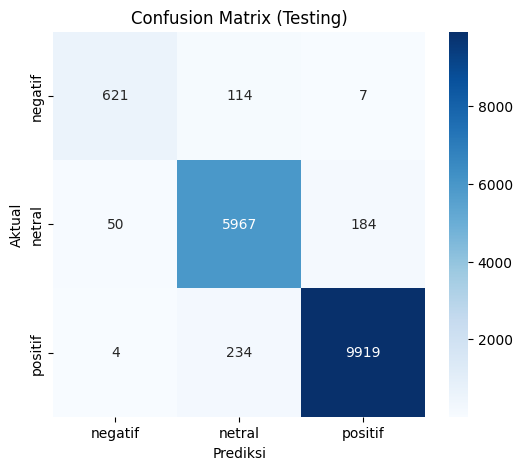

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Arsitektur LSTM Ringan
model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32, return_sequences=False)),   # hanya 1 layer, lebih cepat
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])
model_lstm.summary()

# 2. Callback & Training
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=6,             # jauh lebih singkat
    batch_size=256,       # lebih besar = training cepat
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],
    verbose=1
)

# 3. Evaluasi
print("\nEvaluasi Model LSTM (Versi Cepat)")
y_pred_lstm_train = np.argmax(model_lstm.predict(X_train_pad, verbose=0), axis=1)
y_pred_lstm_test  = np.argmax(model_lstm.predict(X_test_pad, verbose=0), axis=1)

train_acc = accuracy_score(y_train, y_pred_lstm_train) * 100
test_acc  = accuracy_score(y_test, y_pred_lstm_test) * 100

print(f"Akurasi Training: {train_acc:.2f}%")
print(f"Akurasi Testing: {test_acc:.2f}%")

print("\nLaporan Klasifikasi (Testing):")
print(classification_report(y_test, y_pred_lstm_test, target_names=label_encoder.classes_))

# 4. Confusion Matrix Visual
cm = confusion_matrix(y_test, y_pred_lstm_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix (Testing)")
plt.show()


## **Eksperimen 2: SVM**

Eksperimen 2: SVM...
EVALUASI: SVM
Akurasi Training: 96.81%
Akurasi Testing: 96.11%

Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

     negatif       0.86      0.75      0.80       742
      netral       0.94      0.95      0.95      6201
     positif       0.98      0.98      0.98     10157

    accuracy                           0.96     17100
   macro avg       0.93      0.89      0.91     17100
weighted avg       0.96      0.96      0.96     17100

Confusion Matrix (Testing):


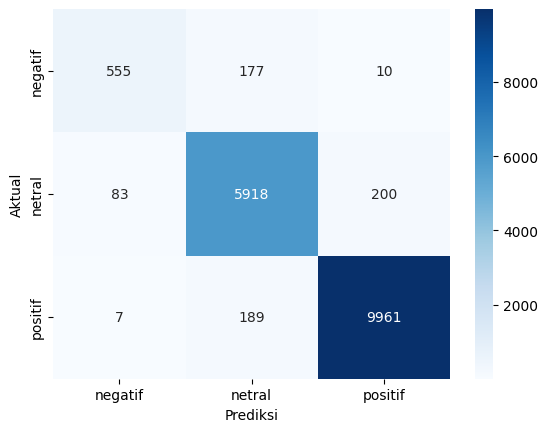

(0.9680701754385965, 0.9610526315789474)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

print("Eksperimen 2: SVM...")

# TF-IDF for SVM
tfidf = TfidfVectorizer(max_features=15000)

# Create a pipeline that first transforms the text using TF-IDF and then trains an SVM model
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=15000)),
    ('svm', SVC(kernel='linear')) # Using a linear kernel for simplicity and speed
])

# Train the SVM model
svm_pipeline.fit(X_train_text, y_train)

# Use the already trained svm_pipeline from cell 8P97hYYPAJHr for prediction
y_pred_svm_train = svm_pipeline.predict(X_train_text)
y_pred_svm_test = svm_pipeline.predict(X_test_text)

# Evaluate the model using the show_evaluation function
show_evaluation("SVM", y_train, y_pred_svm_train, y_test, y_pred_svm_test, label_encoder.classes_)

## **Eksperimen 3: 1D-CNN**

Eksperimen 3: 1D-CNN...
Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.7784 - loss: 0.5374 - val_accuracy: 0.9684 - val_loss: 0.1156
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.9724 - loss: 0.1076 - val_accuracy: 0.9747 - val_loss: 0.0954
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9809 - loss: 0.0708 - val_accuracy: 0.9740 - val_loss: 0.1101
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9866 - loss: 0.0470 - val_accuracy: 0.9694 - val_loss: 0.1305
535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step
EVALUASI: 1D-CNN
Akurasi Training: 98.18%
Akurasi Testing: 97.50%

Laporan Klasifikasi (Testing):
              precision    recall  f1-score   support

     negatif       0.96      0.84      0.90       742
      netral       0.96      0.98      0.97      6201
     positif       0.99      0.98      0.99     10157

    accuracy                           0.98     17100
   m

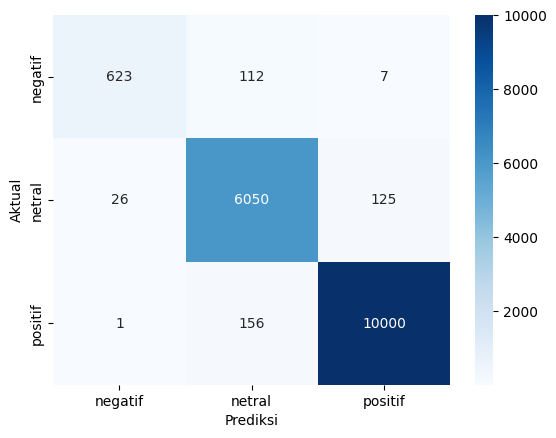

(0.9817690058479532, 0.9750292397660819)

In [47]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

print("Eksperimen 3: 1D-CNN...")

model_cnn = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

y_pred_cnn = model_cnn.predict(X_test_pad).argmax(axis=1)
show_evaluation("1D-CNN", y_train, model_cnn.predict(X_train_pad).argmax(axis=1), y_test, y_pred_cnn, label_encoder.classes_)

## **Pembahasan (Analisis Hasil)**

In [48]:
print("Pembahasan:")

# Recalculate predictions for LSTM and CNN within this cell
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad, verbose=0), axis=1)
y_pred_cnn = model_cnn.predict(X_test_pad).argmax(axis=1)

# Add SVM prediction within this cell
y_pred_svm = svm_pipeline.predict(X_test_text)


# Ambil akurasi tiap model
acc_lstm = accuracy_score(y_test, y_pred_lstm)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_cnn = accuracy_score(y_test, y_pred_cnn)

print(f"Accuracy LSTM : {acc_lstm:.4f}")
print(f"Accuracy SVM  : {acc_svm:.4f}")
print(f"Accuracy CNN  : {acc_cnn:.4f}")

best_model = max(
    [('LSTM', acc_lstm), ('SVM', acc_svm), ('CNN', acc_cnn)],
    key=lambda x: x[1]
)

print(f"\n Model terbaik: {best_model[0]} dengan akurasi {best_model[1]:.4f}")

Pembahasan:
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Accuracy LSTM : 0.9653
Accuracy SVM  : 0.9611
Accuracy CNN  : 0.9750

 Model terbaik: CNN dengan akurasi 0.9750


## **Tahap 6 – Inferensi (Prediksi Manual)**

In [49]:
# Pilih model terbaikmu (misal LSTM jika akurasinya tertinggi)
model_terbaik = model_lstm
nama_kelas = label_encoder.classes_

# Define the preprocess_text function
def preprocess_text(text):
    # Adapted from the cleaning logic used earlier in the notebook
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    # Optional: add slang normalization and filler word removal if needed for inference
    # For simplicity, I will use the basic cleaning logic that was applied to df['basic_clean']
    text = " ".join([w for w in text.split() if w not in stopwords]) # Use 'stopwords'

    return text


# Fungsi pipeline inferensi
def predict_new_sentiment(text_input):
    # 1. Preprocessing teks input
    cleaned_text = preprocess_text(text_input)
    # 2. Tokenisasi dan Padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    # 3. Prediksi
    prediction = model_terbaik.predict(padded_seq)
    # 4. Ambil kelas
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_name = nama_kelas[predicted_class_index]

    # Return probability for the predicted class
    return predicted_class_name, prediction[0][predicted_class_index]

print("Fungsi inferensi 'predict_new_sentiment' siap digunakan.")

# --- BUKTI INFERENSI (UNTUK SCREENSHOT) ---
# Ini adalah bagian yang harus kamu screenshot sebagai bukti
ulasan_baru = [
    "Game ini seru banget, grafiknya mantap! Suka sekali!",
    "Sumpah nge-lag parah, banyak bug, tolong perbaiki developernya",
    "Game nya lumayan lah buat isi waktu luang, tapi b aja",
    "kenapa sekarang jadi susah login dan sering keluar sendiri?",
    "keren abis update terbarunya, makin lancar jaya"
]

print("===== HASIL INFERENSI MODEL TERBAIK =====\n")
for ulasan in ulasan_baru:
    sentimen, probabilitas = predict_new_sentiment(ulasan)
    print(f"Ulasan: '{ulasan}'")
    print(f"Prediksi Sentimen: -> {sentimen.upper()} (Prob: {probabilitas*100:.2f}%)\n")
    print("-" * 30)

Fungsi inferensi 'predict_new_sentiment' siap digunakan.
===== HASIL INFERENSI MODEL TERBAIK =====

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Ulasan: 'Game ini seru banget, grafiknya mantap! Suka sekali!'
Prediksi Sentimen: -> POSITIF (Prob: 99.98%)

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Ulasan: 'Sumpah nge-lag parah, banyak bug, tolong perbaiki developernya'
Prediksi Sentimen: -> NEGATIF (Prob: 99.85%)

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Ulasan: 'Game nya lumayan lah buat isi waktu luang, tapi b aja'
Prediksi Sentimen: -> NETRAL (Prob: 99.63%)

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Ulasan: 'kenapa sekarang jadi susah login dan sering keluar sendiri?'
Prediksi Sentimen: -> NETRAL (Prob: 99.18%)

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Ulasan: 'keren abis update terbarunya, makin lancar jaya'
Prediksi Sentimen: -> POSITIF (Prob: 99.87%)

------------------------------

In [50]:
!pip freeze > requirements.txt

In [51]:
!cat requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.1
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.20.0.39.8
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.2
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.26.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==0.1.90
cla